# **MELANOMA DETECTION**

**PROBLEM STATEMENT :**

Melanoma is a type of cancer that can be deadly if not detected early.It accounts for 75% of skin cancer deaths.
A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.


**The dataset consists of 2367 images** of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC).

All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant



**The data set contains the following diseases:**

Actinic keratosis

Basal cell carcinoma

Dermatofibroma

Melanoma

Nevus

Pigmented benign keratosis

Seborrheic keratosis

Squamous cell carcinoma

Vascular lesion

**Importing all the important libraries**

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.image as mpimg
import warnings
warnings.filterwarnings('ignore')
import os
import PIL
import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization


**Import Skin Cancer Data**

In [2]:
'''# When using the data by mounting google drive, use the following :

from google.colab import drive
drive.mount('/content/gdrive')
root_path = '/content/drive/MyDrive/Cancer File/'''

"# When using the data by mounting google drive, use the following :\n\nfrom google.colab import drive\ndrive.mount('/content/gdrive')\nroot_path = '/content/drive/MyDrive/Cancer File/"

In [3]:
# Defining the path for train and test images

root_path = '/content/drive/MyDrive/Cancer File/'
data_dir_train = pathlib.Path(root_path+'Train/')
data_dir_test = pathlib.Path(root_path+'Test/')


In [4]:
# Number of images in the train and test set

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118



*   Dataset contains about 2367 images of skin cancer types.
*   It contains 9 sub-directories in each train and test subdirectories.
*  The 9 sub-directories contains the images of 9 skin cancer types respectively.



##**Load using keras.preprocessing**

Let's load these images off disk using the helpful image_dataset_from_directory utility.

###**Create a dataset**

In [5]:
# Define some parameters for the loader

batch_size = 32
img_height = 180
img_width = 180
num_classes = 9

**Using 80% of the images for training, and 20% for validation.**



In [6]:
# TRAIN DATASET
# Dataset is created using seed=123 and tf.keras.preprocessing.image_dataset_from_directory
# Resizing images to the size img_height*img_width, while writing the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
# VALIDATION DATASET
# Dataset is created using seed=123 and tf.keras.preprocessing.image_dataset_from_directory
# Resizing images to the size img_height*img_width, while writing the dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# We can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### **Visualize the data**


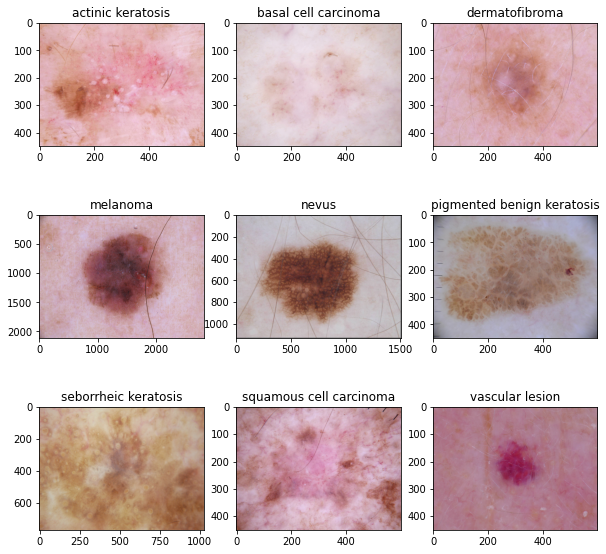

In [9]:
# Visualizing sample image from each class

plt.figure(figsize=(10,10))
for i in range(9): 
  plt.subplot(3, 3, i + 1)
  image = mpimg.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.


Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.


Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## **MODEL 1 :**

### **Create the model**

In [11]:
# Create a CNN model
# Using layers.experimental.preprocessing.Rescaling, normalize pixel values between (0,1)

model = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))])

# 1st convolution layer
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

# 2nd convolution layer
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

# 3rd convolution layer
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

# 4th convolution layer 
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())

# Fully connected layer 1
model.add(Dense(128, activation='relu'))

# Fully connected layer 2
model.add(Dense(128, activation='relu'))

# Output layer
model.add(Dense(num_classes, activation = "softmax"))

### **Compile the model**

Optimiser chosen in Adam and the loss function used for model training is SparseCategoricalCrossentropy.

In [12]:
# Compile the model using 'adam' optimizer and 'SparseCategoricalCrossentropy' loss function

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
# View the summary of all layers

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### **Train the model**


In [14]:
# Train the model for 20 epochs 

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 304s 1s/step - loss: 2.0705 - accuracy: 0.1875 - val_loss: 2.0361 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 1s 25ms/step - loss: 2.0170 - accuracy: 0.1914 - val_loss: 1.9487 - val_accuracy: 0.2998
Epoch 3/20
56/56 [==============================] - 1s 25ms/step - loss: 1.8731 - accuracy: 0.3092 - val_loss: 1.6910 - val_accuracy: 0.3826
Epoch 4/20
56/56 [==============================] - 1s 25ms/step - loss: 1.6190 - accuracy: 0.4230 - val_loss: 1.4903 - val_accuracy: 0.5213
Epoch 5/20
56/56 [==============================] - 1s 25ms/step - loss: 1.4966 - accuracy: 0.4738 - val_loss: 1.5213 - val_accuracy: 0.4899
Epoch 6/20
56/56 [==============================] - 1s 25ms/step - loss: 1.3721 - accuracy: 0.5229 - val_loss: 1.3685 - val_accuracy: 0.5190
Epoch 7/20
56/56 [==============================] - 1s 25ms/step - loss: 1.3381 - accuracy: 0.5218 - val_loss: 1.3981 - val_accuracy: 0.4810
Epoch 8/20
56

### **Visualize the results**


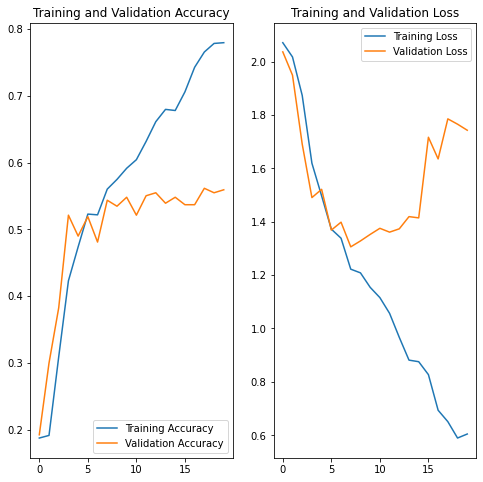

In [15]:
# Visualize the results 

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **Findings**

*   Training accuracy increases as the number of epochs increase wheras validation accuracy increases only for a first few epochs but then starts fluctuating and also the difference between training accuracy and validation accuracy is huge.


*   Also, training loss seems to decline with increase in epochs whereas validation loss increases after some epochs.


**Training accuracy**: ~ 0.78

**Validation accuracy**: ~ 0.56

*   These observations are a clear evidence of OVERFITTING.

*   Thus, to prevent overfitting let us use data augmentation along with Dropout layers and L2 regularizers.




In [16]:
# Since the model overfits, data augumentation strategy is used
# Data augmentation is artificially increasing the amount of data needed to train robust AI models

data_aug = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",
                                                                          input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), 
                                                                          width_factor=(0.2, 0.3), fill_mode='reflect')
])

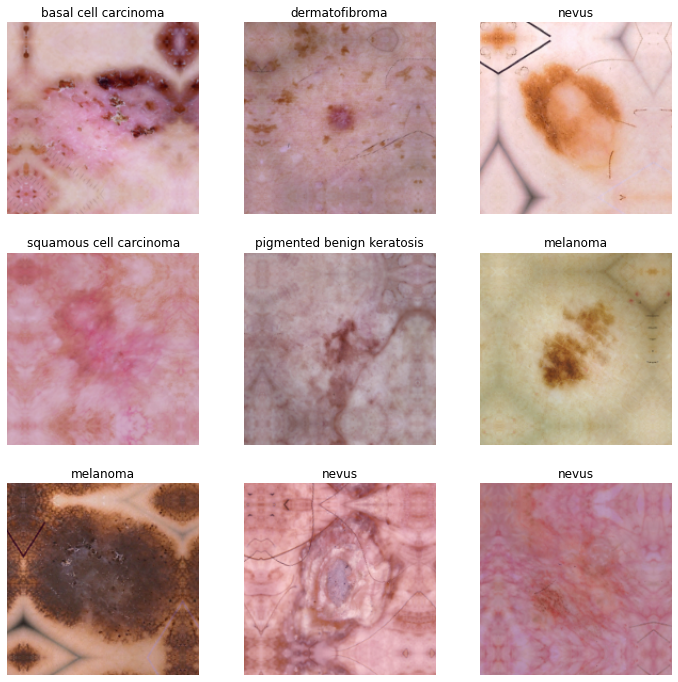

In [17]:
# Visualize the augmentation strategy and let us see how it works for one instance of training image

plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_aug(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## **MODEL 2 :**

### **Create the model**

In [18]:
# Let us create a new model with Dropout layer and l2 regularizer as the previous model overfits
# Use the augmented data for creating the model
# Let us add one more layer to improve accuracy

model = Sequential([ data_aug,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))])

# 1st convolution layer with Dropout layer
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.10))

# 2nd convolution layer with Dropout layer
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.20))

# 3rd convolution layer with Dropout layer
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.10))

# 4th convolution layer with Dropout layer
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.20))

# 5th convolution layer with Dropout layer
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.10))

model.add(Flatten())

# Fully connected layer 1 with l2 regularizer
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.02)))

# Fully connected layer 2 with Dropout layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.10))

# Output layer
model.add(Dense(num_classes, activation = "softmax"))

### **Compile the model**


In [19]:
# Compile the model using 'adam' optimizer and 'SparseCategoricalCrossentropy' loss function

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
# View the summary of all layers

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 90, 90, 16)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 32)        4640      
                                                      

### **Train the model**


In [21]:
# Train the model for 20 epochs

epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 3s 33ms/step - loss: 3.7139 - accuracy: 0.1780 - val_loss: 2.3454 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 2s 29ms/step - loss: 2.1247 - accuracy: 0.1914 - val_loss: 1.9961 - val_accuracy: 0.3266
Epoch 3/20
56/56 [==============================] - 2s 29ms/step - loss: 1.9339 - accuracy: 0.2924 - val_loss: 1.9109 - val_accuracy: 0.2975
Epoch 4/20
56/56 [==============================] - 2s 29ms/step - loss: 1.8620 - accuracy: 0.2857 - val_loss: 1.8395 - val_accuracy: 0.2975
Epoch 5/20
56/56 [==============================] - 2s 29ms/step - loss: 1.7691 - accuracy: 0.3393 - val_loss: 1.6956 - val_accuracy: 0.3893
Epoch 6/20
56/56 [==============================] - 2s 29ms/step - loss: 1.6619 - accuracy: 0.3934 - val_loss: 1.6444 - val_accuracy: 0.4340
Epoch 7/20
56/56 [==============================] - 2s 29ms/step - loss: 1.6158 - accuracy: 0.4062 - val_loss: 1.6326 - val_accuracy: 0.4228
Epoch 8/20
56

### **Visualize the results**


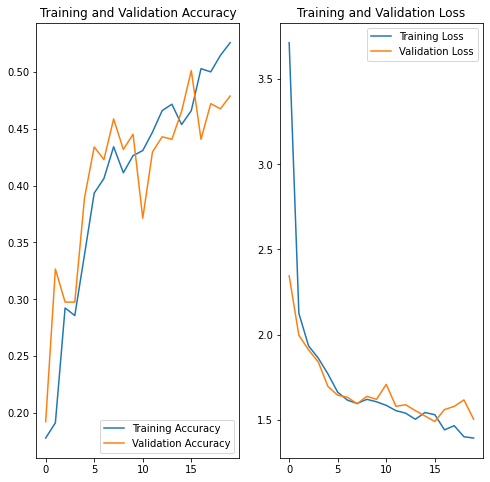

In [22]:
# Visualize the results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



*   As we can see that the difference between the training accuracy and validation accuracy has been shrinked compared to previous model and also it is maintained along every epochs.

*  Thus overfitting its handled in this model by data augmentation and regularizations like Dropout layers and L2 regularizer.

**Training accuracy** : ~ 0.52

**Validation accuracy**: ~ 0.48

**Training loss** : ~ 1.3932

**Validation loss** : ~ 1.5039

*   Still, there is a scope for improvement in accuracy. Let us focus on class imbalance issue and resolve it to get better accuracy and also it aids in preventing overfitting.



### **DISTRIBUTION OF CLASSES IN THE TRAINING DATASET**




*   Many a times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others.

Hence as a sanity check it becomes important to check what is the distribution of classes in the data.
*  Class imbalance can have a detrimental effect on the final model quality.


*   Hence as a sanity check it becomes important to check what is the distribution of classes in the data.








In [23]:
# Create a dictionary of train data image counts with their corresponding classnames

image_count = {}
for classname in class_names:
    image_count[classname] = len(list(data_dir_train.glob(classname+'/*.jpg')))   
print(image_count)

{'actinic keratosis': 114, 'basal cell carcinoma': 376, 'dermatofibroma': 95, 'melanoma': 438, 'nevus': 357, 'pigmented benign keratosis': 462, 'seborrheic keratosis': 77, 'squamous cell carcinoma': 181, 'vascular lesion': 139}


In [24]:
# Create a dataframe for storing the image counts of respective classes

image_count_df = pd.DataFrame()
num_of_images = list(image_count.values())
image_count_df['Class name'] = class_names
image_count_df['Number of images'] = num_of_images
image_count_df

,Class name,Number of images
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


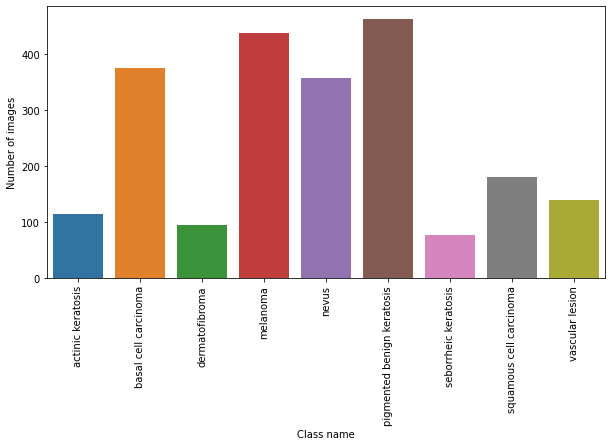

In [25]:
# Plot bar graph to interpret class imbalance in the dataset

plt.figure(figsize=(10, 5))
sns.barplot(x = image_count_df['Class name'], y = image_count_df['Number of images'], data = image_count_df)
plt.xticks(rotation=90)
plt.show()

### **Findings** - 

The class "seborrheic keratosis" has least number of samples.

The class "pigmented benign keratosis" dominate the train data in terms of proportionate number of samples.

In [26]:
pip install Augmentor


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**To use Augmentor, the following general procedure is followed**:

Instantiate a Pipeline object pointing to a directory containing your initial image data set.
Define a number of operations to perform on this data set using your Pipeline object.
Execute these operations by calling the Pipeline’s sample() method.

In [27]:
path_to_training_dataset = root_path+'Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Cancer File/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FE524C70F50>: 100%|██████████| 500/500 [00:23<00:00, 21.14 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Cancer File/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE6437102D0>: 100%|██████████| 500/500 [00:24<00:00, 20.37 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Cancer File/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FE524C488D0>: 100%|██████████| 500/500 [00:22<00:00, 22.41 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Cancer File/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7FE5266EF290>: 100%|██████████| 500/500 [01:53<00:00,  4.40 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Cancer File/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=962x723 at 0x7FE524C1D990>: 100%|██████████| 500/500 [01:30<00:00,  5.53 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Cancer File/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE524D6D690>: 100%|██████████| 500/500 [00:18<00:00, 26.51 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Cancer File/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FE526958110>: 100%|██████████| 500/500 [00:43<00:00, 11.44 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Cancer File/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE525259310>: 100%|██████████| 500/500 [00:18<00:00, 27.40 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Cancer File/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE524C8D910>: 100%|██████████| 500/500 [00:18<00:00, 26.39 Samples/s]


**Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.**

**Lets take a look at total count of augmented images.**

In [28]:
# Total number of added new samples

image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [29]:
# New path

path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#path_list_new

In [30]:
# Respective class names

lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#lesion_list_new


In [31]:
# Zip the paths and its corresponding labels into a dictionary

dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [32]:
# Create a dataframe for storing paths and labels

df = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [33]:
# Check for the number of images in each class

df['Label'].value_counts()

basal cell carcinoma          500
nevus                         500
seborrheic keratosis          500
actinic keratosis             500
squamous cell carcinoma       500
vascular lesion               500
dermatofibroma                500
melanoma                      500
pigmented benign keratosis    500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.




### **Let us train the model on the data created using Augmentor**

In [34]:
batch_size = 32
img_height = 180
img_width = 180
num_classes = 9

### **Create a new training set**


In [35]:
# TRAIN DATASET created using augmented data and original training data
# Dataset is created using seed=123 and tf.keras.preprocessing.image_dataset_from_directory
# Resizing images to the size img_height*img_width

data_dir_train = root_path+'Train/'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


### **Create a new validation set**


In [36]:
# VALIDATION DATASET created using augmented data and original training data
# Dataset is created using seed=123 and tf.keras.preprocessing.image_dataset_from_directory
# Resizing images to the size img_height*img_width

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


## **MODEL 3**


### **Create the model**

In [37]:
# Let us create a new model with augmented data along with the original data

model = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))])

# 1st convolution layer
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

# 2nd convolution layer 
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

# 3rd convolution layer
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

# 4th convolution layer
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

# 5th convolution layer with Dropout layer
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

# Fully connected layer 1 with Dropout layer and l2 regularizer
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.0105)))
model.add(Dropout(0.20))

# Output layer
model.add(Dense(num_classes, activation = "softmax"))

### **Compile the model**


In [38]:
# Compile the model using 'adam' optimizer and 'SparseCategoricalCrossentropy' loss function

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [39]:
# View the summary of all layers

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 45, 45, 32)       

### **Train the model**


In [40]:
# Train the model for 30 epochs

epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
43/43 [==============================] - 8s 134ms/step - loss: 3.2639 - accuracy: 0.1166 - val_loss: 2.3164 - val_accuracy: 0.1790
Epoch 2/30
43/43 [==============================] - 7s 127ms/step - loss: 2.2322 - accuracy: 0.1678 - val_loss: 2.0213 - val_accuracy: 0.3043
Epoch 3/30
43/43 [==============================] - 7s 128ms/step - loss: 2.0925 - accuracy: 0.1722 - val_loss: 1.9861 - val_accuracy: 0.2864
Epoch 4/30
43/43 [==============================] - 6s 125ms/step - loss: 1.9338 - accuracy: 0.2687 - val_loss: 1.7118 - val_accuracy: 0.4295
Epoch 5/30
43/43 [==============================] - 6s 125ms/step - loss: 1.8376 - accuracy: 0.3267 - val_loss: 1.7105 - val_accuracy: 0.4340
Epoch 6/30
43/43 [==============================] - 6s 127ms/step - loss: 1.7449 - accuracy: 0.3541 - val_loss: 1.6301 - val_accuracy: 0.4541
Epoch 7/30
43/43 [==============================] - 6s 127ms/step - loss: 1.6673 - accuracy: 0.3831 - val_loss: 1.5880 - val_accuracy: 0.4877
Epoch 

### **Visualize the results**


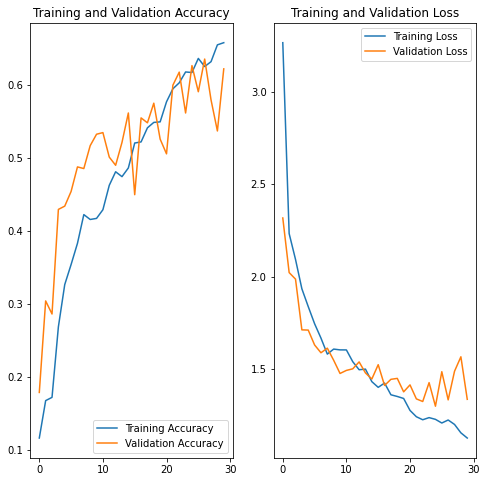

In [41]:
# Visualize the results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **Findings** - 


*   It is evident that class imbalance issue is resolved with Augmentor and we could see an improvement in accuracy.

*   Overfitting issue is also handled as the difference in training accuracy and validation accuracy is remarkably less and By resolving class imbalance issue and using regularizations like dropout layers and l2 regularizers, we obtained better accuracy.


**Training accuracy** : ~ **0.66**

**Validation accuracy** : ~ **0.62**

**Training loss** : ~ **1.1271**

**Validation loss** : ~ **1.3363**


*   Still there may be scope for improvement in accuracy if we increase the number of epochs or number of layers in the model.
